In [1]:
%load_ext autoreload
%autoreload 2

## For refitting.py development

In [2]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import re
import scipy.optimize as opt
from tqdm import tqdm
import sympy as sp
from sympy.parsing.sympy_parser import parse_expr
from sympy import lambdify

In [2]:
filename = 'pareto_low_adv_cleaned.csv'  
t_eq=pd.read_csv('/data/zj448/SR/Ultimate_paper/pareto_archive/'+filename)

df_full = pd.read_csv('SMBH_Data_03_06_24.csv',header=1)

In [3]:
low_scatter_para=['ETG','T-type','Bar', 'Disk', 'Ring', 'Core', 'Multiple', 'Compactness', 'AGN',
       'Pseudobulge', 'BCG', 'cD','M*_sph', 'M*_gal', 'log_B/T',
       'log_sigma0', 'log_R_e_sph_maj','log_R_e_sph_eq_kpc', 'log_n_sph_maj', 'log_n_sph_eq', 'log(I_e,sph,maj/M_Sun/pc^2)',
       'log(I_e,sph,eq/M_Sun/pc^2)', 'Concentration_Index',
       'avg_Rho_1kpc_Exact_All', 'r1_density_approx', 'log10(R10_kpc)',
       'logRho_R10_approx', 'log_rho10_Exact', 'log10(R90_kpc)',
       'logRho_R90_approx', 'log_rho_90_Exact_all', 'Rho_re_spatial',
       'SR_pc_All', 'Rho_SR_pc_All', 'CR_def1_approx_new',
       'Rho_cr_def1_approx_new', 'CR_def2_approx_new',
       'Rho_CR_def2_approx_new', 'Sr(pc)_2_using_Falserm_drho',
       'Log_Approx_Avg_density_10pc', 'log_Rho_e_Exact_new',
       'logRho_e_approx_New', 'logRho_soi_approx_new',
       'log_Rho_soi_exact_new', 'Avg_Rho_Re_Exact_all',
       'Avg_Rho_soi_exact_all', 'Avg_Rho_re_Exact_all', 'Rho_re_Exact_all',
       'Rho_r_soi_2BH_approx', 'Log_Avg_Rho_10kpc_approx',
       'Log_Avg_Rho_10kpc_exact_final', 'Log_Avg_Rho_100pc_approx',
       'Log_Avg_Rho_5kpc_approx', 'Log_Avg_rho_5kpc_exact_all', 'ube', 'bve',
       'dc', 'bvtc', 'bri25', 'mabs', 'blum', 'logblum', 'logSigma0sph',
       'LogSigma0', 'R10', 'logR10', 'logR10phi', 'Rh', 'logRh', 'logRhphi',
       'logHalo','B-V','V-[3.6]','GJC23W1-W2','GJC23W2-W3','GJC23log(M*,gal/M_sun)',
       'GJC23log(SFR)','GJC23log(sSFR)','log<Sigma>_e','log<Sigma>_h','M_BH']

easy_obs_para=['LogSigma0','Concentration_Index','logSigma0sph','log_sigma0','dc','logRhphi','M*_sph','ube','bri25','bve','bvtc','logR10phi','M*_gal','log_B/T',
 'logRh','log_n_sph_eq','blum','log_R_e_sph_maj','logblum','log_n_sph_maj','logR10','Pseudobulge','AGN','Multiple','Ring','BCG','Disk','cD',
 'Bar','Core','Compactness','ETG','T-type','log10(R10_kpc)','log10(R90_kpc)','B-V','V-[3.6]','GJC23W1-W2','GJC23W2-W3','GJC23log(M*,gal/M_sun)','M_BH']

low_scatter_para.append('M_BH_std_sym')
easy_obs_para.append('M_BH_std_sym')

In [4]:
df=df_full[low_scatter_para]
df=df.dropna()
len(df)

93

In [5]:
t_eq['LLL']=0.
t_eq['intrinsic_scatter']=0.
t_eq['refit_equation']=''
t_eq['refit_wrmse']=0.

number_matching_pattern = r"(?<![a-zA-Z0-9_.])[+-]?(\d+\.\d+|\.\d+|\d+\.|\d+)(?:[eE][-+]?\d+)?"


def predict(equation):
    func=str2equ(equation)
    labels = re.findall(r'x(\d+)', equation)
    labels = list(dict.fromkeys(labels))
    labels = [int(label) for label in labels]

    x=[]
    for i in range(len(labels)):
        x.append(df[low_scatter_para[labels[i]]])

    return func(*x)

def str2equ(equation):
    return lambdify(list(dict.fromkeys(re.findall(r'\bx\d+',equation))),equation)

def wrmse(y,y_pred,w):
    return np.average((y-y_pred)**2,weights=w)

mu_obs = df['M_BH']
sigma_y_obs2 = df['M_BH_std_sym']*df['M_BH_std_sym']
w=1/sigma_y_obs2

for row in tqdm(t_eq.iterrows(),total=len(t_eq)):

    equation = row[1]['fitting_format']

    variable_list=[]
    for i in range(row[1]['num_fitting_variables']):
        variable_list.append('p['+str(i)+']')
    
    constants = row[1]['initial_constant_guess']
    constants = eval(constants)
    
    print(equation)

    labels = re.findall(r'x(\d+)', equation)
    labels = list(dict.fromkeys(labels))
    labels = [int(label) for label in labels]

    x=[]
    for i in range(len(labels)):
        x.append(df[low_scatter_para[labels[i]]])

    mu_obs = df['M_BH']

    sigma_y_obs2 = df['M_BH_std_sym']*df['M_BH_std_sym']

    ##############################
    def loglikelihood(p):

        equation_=equation

        # swap constants in for p[i]
        for i in range(len(variable_list)):
            equation_ = equation_.replace(variable_list[i],str(p[i]))

        #print(equation_)

        func = str2equ(equation_)

        mu_pred = func(*x)
        sigma_y =  np.sqrt(sigma_y_obs2 + p[-1]*p[-1])
        #sigma_y =  np.sqrt(sigma_y_obs2)
        norm_residuals = (mu_obs - mu_pred) / sigma_y

        log_l = -0.5*len(df)*np.log(2*np.pi) -np.log(sigma_y).sum() - 0.5*(norm_residuals*norm_residuals).sum()

        #print(log_l)
        return -log_l
    ###############################


    for i in range(len(constants)):
        constants[i]=np.float64(constants[i])
    current_parameter_vector=np.array(constants)
    current_parameter_vector=np.append(current_parameter_vector,0.3) # last p is intrinsic scatter


    result = opt.minimize(loglikelihood, current_parameter_vector, method='Nelder-Mead', tol=1e-5, options={'maxiter':5e4, 'maxfev':5e4, 'adaptive':True})

    new_equation = equation
    for i in range(len(variable_list)):
        new_equation = new_equation.replace(variable_list[i],str(result.x[i]))
    t_eq.loc[row[0],'refit_equation']=new_equation

    refit_wrmse = wrmse(mu_obs,predict(t_eq.iloc[row[0]]['refit_equation']),w)
    if np.isnan(refit_wrmse):
        t_eq.loc[row[0],'refit_wrmse']=np.nan
        t_eq.loc[row[0],'LLL']=np.nan
        t_eq.loc[row[0],'intrinsic_scatter']=np.nan
    
    else:
        t_eq.loc[row[0],'refit_wrmse']=refit_wrmse
        t_eq.loc[row[0],'LLL']=-loglikelihood(current_parameter_vector)
        t_eq.loc[row[0],'intrinsic_scatter']=result.x[-1]

  0%|          | 0/1042 [00:00<?, ?it/s]

  0%|          | 2/1042 [00:00<01:21, 12.70it/s]

x66
x73 + p[0]
-p[1]*x42 + x53 + x69 + p[0]
-p[2]*x42 + x53 + x69 + p[1] - p[4]/(p[3]*x51 + p[0])


  0%|          | 4/1042 [00:02<10:12,  1.69it/s]

p[4]*exp(exp(p[0]/(p[6] - p[1]*x52)**p[5])) + p[2] + log10(p[3]*x23)/x43


  0%|          | 4/1042 [00:05<24:14,  1.40s/it]


KeyboardInterrupt: 

In [8]:
t_eq

,complexity,loss,score,equation,sympy_format,lambda_format,number_constants,variables,number_variables,unique_number_variables,...,aic,evolutions,iterations,fitting_format,num_fitting_variables,initial_constant_guess,LLL,intrinsic_scatter,refit_equation,refit_wrmse
0,1,4.885951,0.000000,x69,x69,PySRFunction(X=>x69),0,{'x69'},1,1,...,908.786973,0,0,x69,0,[],-2644.193704,2.495183,x69,4.885951
1,3,0.157051,1.718773,(x69 + x49),x49 + x69,PySRFunction(X=>x49 + x69),0,"{'x69', 'x49'}",2,2,...,29.211556,0,0,x49 + x69,0,[],-132.237834,0.575609,x49 + x69,0.157051
2,7,0.127908,0.058997,(((x12 + x49) - x73) - x17),x12 - x17 + x49 - x73,PySRFunction(X=>x12 - x17 + x49 - x73),0,"{'x12', 'x49', 'x73', 'x17'}",4,4,...,23.790881,0,0,x12 - x17 + x49 - x73,0,[],-113.504567,0.536001,x12 - x17 + x49 - x73,0.127908
3,11,0.117943,0.020278,(((x69 + x49) - (log10(2.233044520137043) / ex...,x49 + x69 - x73 - 0.8033659100247211*exp(-x56)...,PySRFunction(X=>x49 + x69 - x73 - 0.8033659100...,1,"{'x69', 'x49', 'x73', 'x56'}",4,4,...,23.937366,0,0,x49 + x69 - x73 - log10(p[0])*exp(-x56),1,['2.233044520137043'],NaN,NaN,x49 + x69 - x73 - log10(-0.19310753116117474)*...,NaN
4,15,0.105290,0.028371,((((x13 + x53) + -0.4385317648318854) + (((0.5...,x13 + x53 - x65 + (0.5787281095217448**x42)**1...,PySRFunction(X=>x13 + x53 - x65 + (0.578728109...,4,"{'x42', 'x65', 'x13', 'x53'}",4,4,...,27.583895,0,0,x13 + x53 - x65 + (p[0]**x42)**p[1] - p[2],3,"['0.5787281095217448', '1.1072374946867565', '...",-75.852376,0.438619,x13 + x53 - x65 + (0.566708231503907**x42)**0....,0.108121
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59,13,0.021503,0.158455,(((x15 / 0.2781055358753451) + x19) - (log10(e...,3.595757261186734*x15 + x19 - log(exp(x42)/x21...,PySRFunction(X=>3.595757261186734*x15 + x19 - ...,2,"{'x42', 'x19', 'x15', 'x21'}",4,4,...,7.999501,0,1872,p[0]*x15 + x19 - log10(exp(x42)/x21) + p[1],2,"['3.595757261186734', '0.38990846927012623']",-21.956161,0.239813,3.422088700384049*x15 + x19 - log10(exp(x42)/x...,0.023058
60,19,0.019478,0.001638,(((x15 / 0.2781055358753451) + x19) - (log10((...,3.595757261186734*x15 + x19 - log((x2 + x8 + e...,PySRFunction(X=>3.595757261186734*x15 + x19 - ...,3,"{'x42', 'x19', 'x2', 'x15', 'x21', 'x8'}",6,6,...,9.622973,0,1872,p[0]*x15 + x19 - log10((x2 + x8 + exp(x42) - p...,3,"['3.595757261186734', '0.5889051845565962', '0...",-19.347105,0.223603,3.321319736068659*x15 + x19 - log10((x2 + x8 +...,0.020402
61,21,0.019439,0.001002,(((x15 / 0.2781055358753451) + x19) - (log10((...,3.595757261186734*x15 + x19 - log((x2 + x73 + ...,PySRFunction(X=>3.595757261186734*x15 + x19 - ...,3,"{'x42', 'x19', 'x2', 'x15', 'x21', 'x8', 'x73'}",7,7,...,9.615720,0,1872,p[0]*x15 + x19 - log10((x2 + x73 + x8 + exp(x4...,3,"['3.595757261186734', '0.5889051845565962', '0...",-19.124593,0.222083,3.310923746501202*x15 + x19 - log10((x2 + x73 ...,0.020351
62,4,0.115187,0.184676,(log10(x15) * 23.41780258431442),23.41780258431442*log(x15)/log(10),PySRFunction(X=>23.41780258431442*log(x15)/log...,1,{'x15'},1,1,...,23.424861,0,1908,p[0]*log10(x15),1,['23.41780258431442'],-96.489604,0.480893,23.07503029440484*log10(x15),0.130350


## Visualize the results of refitting.py

In [3]:
filename = 'pareto_low_adv_cleaned.csv'
t_eq = pd.read_csv('/data/zj448/SR/Ultimate_paper/pareto_archive/'+filename[:-12]+'_refit.csv')

In [4]:
# for i in range(100):
#     display(parse_expr(t_eq.iloc[i]['refit_equation']))

In [5]:
df_full = pd.read_csv('SMBH_Data_03_06_24.csv',header=1)

low_scatter_para=['ETG','T-type','Bar', 'Disk', 'Ring', 'Core', 'Multiple', 'Compactness', 'AGN',
       'Pseudobulge', 'BCG', 'cD','M*_sph', 'M*_gal', 'log_B/T',
       'log_sigma0', 'log_R_e_sph_maj','log_R_e_sph_eq_kpc', 'log_n_sph_maj', 'log_n_sph_eq', 'log(I_e,sph,maj/M_Sun/pc^2)',
       'log(I_e,sph,eq/M_Sun/pc^2)', 'Concentration_Index',
       'avg_Rho_1kpc_Exact_All', 'r1_density_approx', 'log10(R10_kpc)',
       'logRho_R10_approx', 'log_rho10_Exact', 'log10(R90_kpc)',
       'logRho_R90_approx', 'log_rho_90_Exact_all', 'Rho_re_spatial',
       'SR_pc_All', 'Rho_SR_pc_All', 'CR_def1_approx_new',
       'Rho_cr_def1_approx_new', 'CR_def2_approx_new',
       'Rho_CR_def2_approx_new', 'Sr(pc)_2_using_Falserm_drho',
       'Log_Approx_Avg_density_10pc', 'log_Rho_e_Exact_new',
       'logRho_e_approx_New', 'logRho_soi_approx_new',
       'log_Rho_soi_exact_new', 'Avg_Rho_Re_Exact_all',
       'Avg_Rho_soi_exact_all', 'Avg_Rho_re_Exact_all', 'Rho_re_Exact_all',
       'Rho_r_soi_2BH_approx', 'Log_Avg_Rho_10kpc_approx',
       'Log_Avg_Rho_10kpc_exact_final', 'Log_Avg_Rho_100pc_approx',
       'Log_Avg_Rho_5kpc_approx', 'Log_Avg_rho_5kpc_exact_all', 'ube', 'bve',
       'dc', 'bvtc', 'bri25', 'mabs', 'blum', 'logblum', 'logSigma0sph',
       'LogSigma0', 'R10', 'logR10', 'logR10phi', 'Rh', 'logRh', 'logRhphi',
       'logHalo','B-V','V-[3.6]','GJC23W1-W2','GJC23W2-W3','GJC23log(M*,gal/M_sun)',
       'GJC23log(SFR)','GJC23log(sSFR)','log<Sigma>_e','log<Sigma>_h','M_BH']

easy_obs_para=['LogSigma0','Concentration_Index','logSigma0sph','log_sigma0','dc','logRhphi','M*_sph','ube','bri25','bve','bvtc','logR10phi','M*_gal','log_B/T',
 'logRh','log_n_sph_eq','blum','log_R_e_sph_maj','logblum','log_n_sph_maj','logR10','Pseudobulge','AGN','Multiple','Ring','BCG','Disk','cD',
 'Bar','Core','Compactness','ETG','T-type','log10(R10_kpc)','log10(R90_kpc)','B-V','V-[3.6]','GJC23W1-W2','GJC23W2-W3','GJC23log(M*,gal/M_sun)','M_BH']

low_scatter_para.append('M_BH_std_sym')
easy_obs_para.append('M_BH_std_sym')

if 'low' in filename:
    df=df_full[low_scatter_para]
if 'easy' in filename:
    df=df_full[easy_obs_para]
df=df.dropna()
len(df)

93

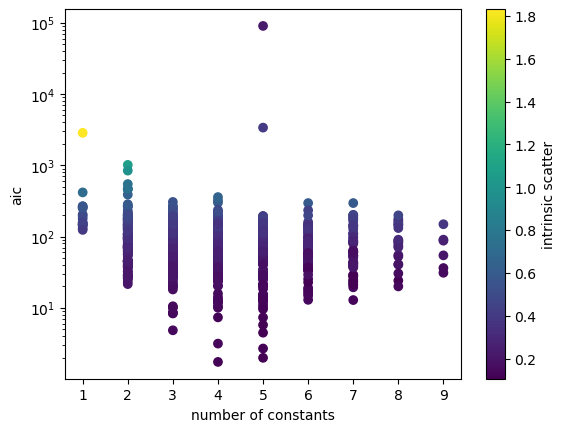

In [6]:
aic = -2*t_eq['LLL']+2*(t_eq['number_constants']+1)
t_eq['AIC']=aic
plt.scatter(t_eq['number_constants']+1,aic,c=t_eq['intrinsic_scatter'])
plt.xlabel('number of constants')
plt.ylabel('aic')
#plt.ylim(0,1000)
plt.yscale('log')
plt.colorbar().set_label('intrinsic scatter')

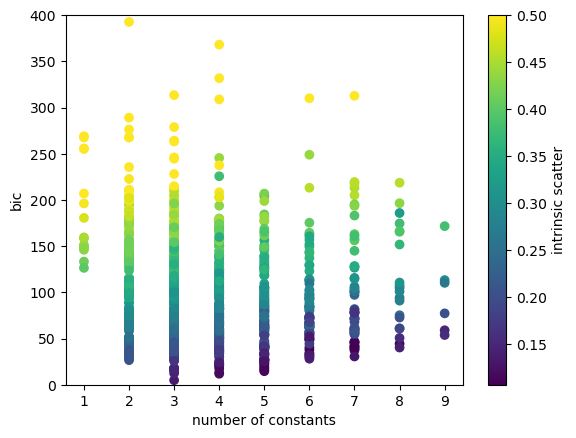

In [7]:
bic = -2*t_eq['LLL']+np.log(len(df))*(t_eq['number_constants']+1)
t_eq['BIC']=bic
plt.scatter(t_eq['number_constants']+1,bic,c=np.clip(t_eq['intrinsic_scatter'],0,0.5))
plt.xlabel('number of constants')
plt.ylabel('bic')
plt.ylim(0,400)
#plt.yscale('log')
plt.colorbar().set_label('intrinsic scatter')

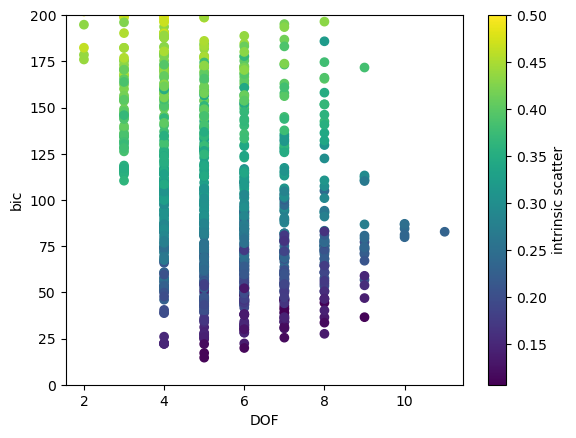

In [8]:
dof = np.maximum(t_eq['number_constants'],t_eq['unique_number_variables'])+1
bic = np.array(-2*t_eq['LLL']+np.log(len(df))*dof)
t_eq['BIC']=bic
t_eq['DOF']=dof
plt.scatter(dof,bic,c=np.clip(t_eq['intrinsic_scatter'],0,0.5))
plt.xlabel('DOF')
plt.ylabel('bic')
plt.ylim(0,200)
#plt.yscale('log')
plt.colorbar().set_label('intrinsic scatter')

In [9]:
#aic.argmin()

In [10]:
bic.argsort(),bic[bic.argsort()]

(array([653, 652, 654, ...,  83, 995, 808]),
 array([14.65025918, 17.13927014, 19.88061074, ...,         nan,
                nan,         nan]))

In [11]:
def view_equation(index,var_list=low_scatter_para,t_eq=t_eq):
    print('equation:',parse_expr(t_eq.iloc[index]['refit_equation']))
    display(parse_expr(t_eq.iloc[index]['refit_equation']))
    unique_variables = list(dict.fromkeys(re.findall(r'\bx\d+',t_eq.iloc[index]['refit_equation'])))
    #print(unique_variables)
    for i in range(len(unique_variables)):
        print(unique_variables[i],':',var_list[int(unique_variables[i][1:])])
    
    print('intrinsic scatter:',t_eq.iloc[index]['intrinsic_scatter'])
    print('wrmse:',t_eq.iloc[index]['refit_wrmse'])
    print('AIC:',t_eq.iloc[index]['AIC'])
    print('BIC:',t_eq.iloc[index]['BIC'])
    print('DOF:',t_eq.iloc[index]['DOF'])
    return None

In [12]:
print('Top1: index',bic.argsort()[0])
view_equation(bic.argsort()[0])

Top1: index 653
equation: x15*(-x42/(x39 - 0.3167230750170285*x9**3.1865675724962137) + 3.1865675724962137) + 2.8150715678889657


x15*(-x42/(x39 - 0.3167230750170285*x9**3.1865675724962137) + 3.1865675724962137) + 2.8150715678889657

x15 : log_sigma0
x42 : logRho_soi_approx_new
x39 : Log_Approx_Avg_density_10pc
x9 : Pseudobulge
intrinsic scatter: 0.1103512466094481
wrmse: 0.0110927234763246
AIC: 1.9872617114596842
BIC: 14.650259177225966
DOF: 5


In [13]:
print('Top2: index',bic.argsort()[1])
view_equation(bic.argsort()[1])

Top2: index 652
equation: x15*(-x42/(x39 - 0.3167222239015659*x9) + 3.1865666325111657) + 2.815073609119419


x15*(-x42/(x39 - 0.3167222239015659*x9) + 3.1865666325111657) + 2.815073609119419

x15 : log_sigma0
x42 : logRho_soi_approx_new
x39 : Log_Approx_Avg_density_10pc
x9 : Pseudobulge
intrinsic scatter: 0.1103507406208933
wrmse: 0.0110927222533735
AIC: 4.476272671352138
BIC: 17.13927013711842
DOF: 5


In [14]:
view_equation(bic.argsort()[2])

equation: x15*(-x42/(x39 - 0.43242462237853263*log10(exp(exp(x9))/x78)) + 3.271260721331937) + 2.596838320762477


x15*(-x42/(x39 - 0.43242462237853263*log10(exp(exp(x9))/x78)) + 3.271260721331937) + 2.596838320762477

x15 : log_sigma0
x42 : logRho_soi_approx_new
x39 : Log_Approx_Avg_density_10pc
x9 : Pseudobulge
x78 : log<Sigma>_e
intrinsic scatter: 0.1137664802087505
wrmse: 0.0093572027136544
AIC: 2.6850137771690115
BIC: 19.88061073608855
DOF: 6


In [15]:
# [rank]^th best (in terms of [criteria]) with dof = [ndof]
ndof = 3
rank = 0
criteria = 'BIC'
t_eq_dof=t_eq[t_eq['DOF']==ndof]
view_equation(np.array(t_eq_dof[criteria]).argsort()[rank],t_eq=t_eq_dof)

equation: x39 - x42 + 7.417229618167781


x39 - x42 + 7.417229618167781

x39 : Log_Approx_Avg_density_10pc
x42 : logRho_soi_approx_new
intrinsic scatter: 0.3631079330428152
wrmse: 0.073634484714086
AIC: 100.81166275997816
BIC: 110.40946123943793
DOF: 3


In [16]:
# [rank]^th best (in terms of [criteria]) with number of variables = [nvar]
nvar = 1
rank = 0
criteria = 'BIC'
t_eq_var=t_eq[t_eq['unique_number_variables']==nvar]
view_equation(np.array(t_eq_var[criteria]).argsort()[rank],t_eq=t_eq_var)

equation: 0.5158951241986962*exp(x15) + 3.110169491559339


0.5158951241986962*exp(x15) + 3.110169491559339

x15 : log_sigma0
intrinsic scatter: 0.4232453072395818
wrmse: 0.1074475028206057
AIC: 159.493044939766
BIC: 167.0908434192258
DOF: 3


In [17]:
# [rank]^th best (in terms of [criteria]) with number of variables = [nvar]
nvar = 1
rank = 0
criteria = 'intrinsic_scatter'
t_eq_var=t_eq[t_eq['unique_number_variables']==nvar]
view_equation(np.array(t_eq_var[criteria]).argsort()[rank],t_eq=t_eq_var)

equation: 0.08732693504789066*x15**4.202422104946601 + 5.3324241699592125


0.08732693504789066*x15**4.202422104946601 + 5.3324241699592125

x15 : log_sigma0
intrinsic scatter: 0.4207947157917259
wrmse: 0.1088582546123185
AIC: 165.23148693565787
BIC: 175.3618849082709
DOF: 4


In [18]:
# [rank]^th best (in terms of [criteria]) with PySR complexity = [complexity]
complexity = 13
rank = 0
criteria = 'intrinsic_scatter'
t_eq_var=t_eq[t_eq['complexity']==complexity]
view_equation(np.array(t_eq_var[criteria]).argsort()[rank],t_eq=t_eq_var)

equation: x15*(-x42/(-0.17331871941783772**x71 + x39) + 3.189686636298002) + 2.885129763372674


x15*(-x42/(-0.17331871941783772**x71 + x39) + 3.189686636298002) + 2.885129763372674

x15 : log_sigma0
x42 : logRho_soi_approx_new
x71 : B-V
x39 : Log_Approx_Avg_density_10pc
intrinsic scatter: 0.1173553819869629
wrmse: 0.0130950069051254
AIC: 7.343308920304132
BIC: 22.006306386070413
DOF: 5


In [19]:
t_eq.columns

Index(['complexity', 'loss', 'score', 'equation', 'sympy_format',
       'lambda_format', 'number_constants', 'variables', 'number_variables',
       'unique_number_variables', 'evolutions', 'iterations', 'fitting_format',
       'num_fitting_variables', 'initial_constant_guess', 'LLL',
       'intrinsic_scatter', 'refit_equation', 'refit_wrmse', 'AIC', 'BIC',
       'DOF'],
      dtype='object')

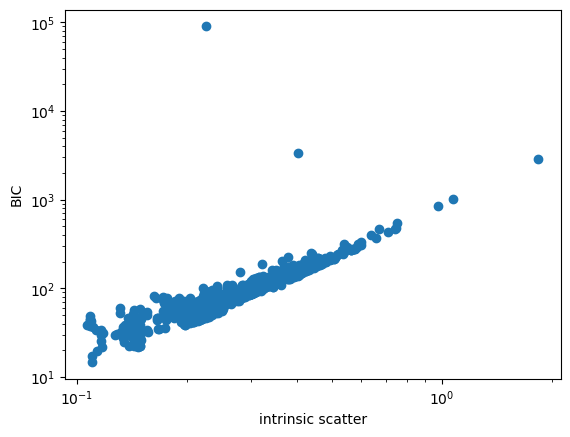

In [20]:
plt.scatter(t_eq['intrinsic_scatter'],t_eq['BIC'])
plt.xlabel('intrinsic scatter')
plt.ylabel('BIC')
plt.yscale('log')
plt.xscale('log')

(-2000.0, 500.0)

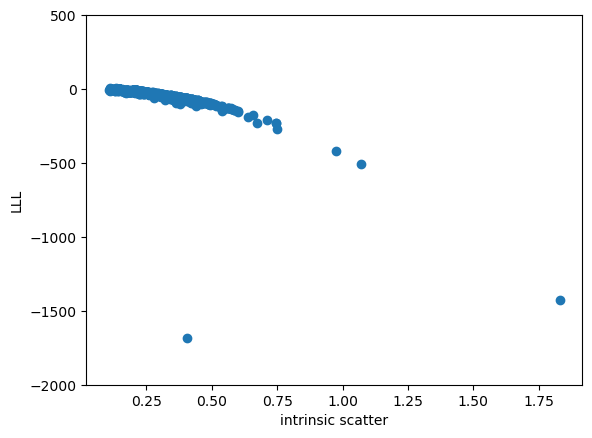

In [23]:
plt.scatter(t_eq['intrinsic_scatter'],t_eq['LLL'])
plt.xlabel('intrinsic scatter')
plt.ylabel('LLL')
plt.ylim(-2000,500)
#plt.yscale('log')
#plt.xscale('log')

In [22]:
t_eq

,complexity,loss,score,equation,sympy_format,lambda_format,number_constants,variables,number_variables,unique_number_variables,...,fitting_format,num_fitting_variables,initial_constant_guess,LLL,intrinsic_scatter,refit_equation,refit_wrmse,AIC,BIC,DOF
0,1,2.422899,0.000000,x66,x66,PySRFunction(X=>x66),0,{'x66'},1,1,...,x66,0,[],-1424.139485,1.830990,x66,2.422899,2850.278970,2857.344169,2
1,3,0.793023,0.558434,(x73 - -8.377161567514106),x73 + 8.377161567514106,PySRFunction(X=>x73 + 8.377161567514106),1,{'x73'},1,1,...,x73 + p[0],1,['8.37716156751411'],-503.997916,1.069723,x73 + 8.120512184890048,0.858892,1011.995832,1017.061031,2
2,13,0.095263,0.020015,(((0.45731312294876897 - (((x42 - -0.353818247...,-0.45018841361960323*x42 + x53 + x69 + 0.29802...,PySRFunction(X=>-0.45018841361960323*x42 + x53...,4,"{'x53', 'x69', 'x42'}",3,3,...,-p[0]*x42 + x53 + x69 + p[1],2,"['0.450188413619603', '0.298028247506404']",-90.130444,0.476856,-0.3753177359347113*x42 + x53 + x69 + 0.067348...,0.096992,190.260888,202.923886,5
3,17,0.090620,0.001319,((((0.13631070516777483 - ((x42 * (0.556125855...,-0.46524650939821102*x42 + x53 + x69 + 0.39610...,PySRFunction(X=>-0.46524650939821102*x42 + x53...,6,"{'x53', 'x69', 'x42'}",3,3,...,-p[1]*x42 + x53 + x69 + p[0],2,"['0.396106010486694', '0.465246509398211']",-92.883246,0.476855,-0.37531951644419825*x42 + x53 + x69 + 0.06735...,0.096992,199.766493,217.494689,7
4,19,0.090473,0.000813,((((0.45731312294876897 - ((x42 * 0.5561258553...,-0.45018841361960323*x42 + x53 + x69 + 0.45731...,PySRFunction(X=>-0.45018841361960323*x42 + x53...,6,"{'x53', 'x69', 'x42', 'x51'}",4,4,...,-p[1]*x42 + x53 + x69 + p[0] - p[2]/(p[3]*x51 ...,5,"['0.457313122948769', '0.450188413619603', '0....",-90.686958,0.454678,-0.4229420667397843*x42 + x53 + x69 + 0.474344...,0.091732,195.373916,213.102113,7
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1017,23,0.011585,0.056926,((((x15 / 0.31852133710431946) + (exp(x79) ^ -...,3.1395071020704912*x15 + (x39 - x42)/(x17/(x28...,PySRFunction(X=>3.1395071020704912*x15 + (x39 ...,3,"{'x42', 'x79', 'x19', 'x39', 'x15', 'x64', 'x1...",8,8,...,p[2]*x15 + (x39 - x42)/(x17/(x28*x64) + exp(x1...,3,"['0.000395449818763269', '0.28986004884971', '...",-3.045656,0.140435,2.9878660600448335*x15 + (x39 - x42)/(x17/(x28...,0.011424,14.091311,46.884707,9
1018,22,0.012256,0.010969,((((x15 / 0.31852133710431946) + (x23 ^ -0.000...,3.1395071020704912*x15 + x23**(-0.000395449818...,PySRFunction(X=>3.1395071020704912*x15 + x23**...,4,"{'x42', 'x19', 'x23', 'x39', 'x15', 'x64', 'x28'}",7,7,...,p[3]*x15 + x23**(-p[0]) + (x39 - x42)/(exp(x19...,4,"['0.000395449818763269', '0.28986004884971', '...",-5.116673,0.146195,2.9220140196249513*x15 + x23**(--0.01158307249...,0.011319,20.233347,46.494143,8
1019,6,0.044143,0.436999,(log10(x15) * (26.037329703202072 - x42)),(26.037329703202072 - x42)*log(x15)/log(10),PySRFunction(X=>(26.037329703202072 - x42)*log...,1,"{'x42', 'x15'}",2,2,...,(p[0] - x42)*log10(x15),1,['26.0373297032021'],-57.242537,0.379120,(25.844373617613577 - x42)*log10(x15),0.048948,118.485073,128.082872,3
1020,12,0.014401,0.510440,(((x15 / 0.31852133710431946) + ((x39 - x42) /...,3.1395071020704912*x15 + (x39 - x42)*exp(-x19)...,PySRFunction(X=>3.1395071020704912*x15 + (x39 ...,2,"{'x19', 'x42', 'x15', 'x39'}",4,4,...,p[1]*x15 + (x39 - x42)*exp(-x19) + p[0],2,"['0.662538219789564', '3.13950710207049']",-6.039985,0.166918,2.849756961078741*x15 + (x39 - x42)*exp(-x19) ...,0.013362,18.079970,34.742967,5
